In [8]:
import numpy as np 
from transformers import AutoTokenizer
from torch.utils.data import Dataset
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
import torch

# Convert data to format

- images to temporal images
- text to encodings

In [ ]:
X = np.load("/its/home/drs25/Documents/data/Tactile Dataset/datasets/X_data_15.npz")['arr_0']
y = np.load("/its/home/drs25/Documents/data/Tactile Dataset/datasets/y_data_15.npz")['arr_0']
print(X)
keys=['Carpet', 'LacedMatt', 'wool', 'Cork', 'Felt', 'LongCarpet', 'cotton', 'Plastic', 'Flat', 'Ffoam', 'Gfoam', 'bubble', 'Efoam', 'jeans', 'Leather']
material_descriptions = {
    "Carpet": "Dense, woven fibers, soft yet coarse, typically synthetic or wool blend.",
    "LacedMatt": "Light, airy mesh structure with interwoven hard lace patterns; bumpy and flexible.",
    "Wool": "Natural fiber, soft, warm, and slightly scratchy; high friction texture.",
    "Cork": "Lightweight, firm but compressible, slightly rough with granular texture.",
    "Felt": "Compressed fabric, soft and smooth surface, uniform texture with slight give.",
    "LongCarpet": "High-pile carpet with long fibers, soft and plush, deep texture.",
    "Cotton": "Smooth and soft woven fabric, breathable with moderate friction.",
    "Plastic": "Hard, smooth surface with low friction; can vary from rigid to flexible.",
    "Flat": "Smooth and even surface, minimal texture; likely hard or semi-soft material.",
    "Ffoam": "Soft with slight springiness, absorbs pressure well.",
    "Gfoam": "Grainy foam, slightly rougher texture, spongy and compressible.",
    "Bubble": "Bubble wrap or bubbled plastic, soft with raised circular nodes, very bumpy.",
    "Efoam": "Soft with slight springiness, absorbs pressure well.",
    "Jeans": "Sturdy cotton denim, rough woven texture, moderate friction.",
    "Leather": "Smooth and durable natural material, slightly soft with subtle grain."
}
new_y=[]
for i in range(len(y)):
    label=keys[y[i]]
    new_y.append(material_descriptions[label])

String conversion

In [10]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")  # or "gpt2", etc.

text = new_y
tokenized = tokenizer(text, padding="max_length", truncation=True, return_tensors="pt")
print(tokenized)
input_ids=tokenized['input_ids']
print(input_ids)  
decoded=tokenizer.decode(input_ids[0].squeeze(), skip_special_tokens=True)
print(decoded)
y=decoded

{'input_ids': tensor([[ 8678,  1774,     1,  ...,     0,     0,     0],
        [13441,   574,     1,  ...,     0,     0,     0],
        [ 3735, 20382,    53,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}
tensor([[ 8678,  1774,     1,  ...,     0,     0,     0],
        [13441,   574,     1,  ...,     0,     0,     0],
        [ 3735, 20382,    53,  ...,     0,     0,     0]])
rough surface


In [11]:
def tokenize_captions(captions, max_len=30):
    return tokenizer(
        captions,
        padding="max_length",
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

# Train model to predict text

In [12]:
class TactileDataset(Dataset):
    def __init__(self, images, captions, tokenizer, max_len=30):
        self.images = images
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.captions = captions

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        caption = self.captions[idx]

        tokens = self.tokenizer(caption, max_length=self.max_len,
                                padding="max_length", truncation=True,
                                return_tensors="pt")
        
        return {
            "image": image,
            "input_ids": tokens["input_ids"].squeeze(0),
            "attention_mask": tokens["attention_mask"].squeeze(0)
        }


In [13]:
class TactileCaptioningModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=512, max_len=30):
        super().__init__()
        # Image encoder: ResNet18 without classifier
        resnet = models.resnet18(pretrained=True)
        resnet.fc = nn.Identity()
        self.encoder = resnet

        # Project image features
        self.img_proj = nn.Linear(512, embed_dim)

        # Text decoder: Embedding + Transformer Decoder
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=4)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=2)

        self.output_layer = nn.Linear(embed_dim, vocab_size)

    def forward(self, images, input_ids):
        batch_size = images.size(0)
        image_features = self.encoder(images)  # (B, 512)
        image_features = self.img_proj(image_features)  # (B, E)
        image_features = image_features.unsqueeze(1)  # (B, 1, E)

        tgt = self.embedding(input_ids)  # (B, T, E)
        tgt = tgt.transpose(0, 1)  # (T, B, E)
        memory = image_features.transpose(0, 1)  # (1, B, E)

        out = self.transformer_decoder(tgt, memory)  # (T, B, E)
        out = out.transpose(0, 1)  # (B, T, E)

        return self.output_layer(out)

In [14]:
model = TactileCaptioningModel(vocab_size=tokenizer.vocab_size)
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

dataset = TactileDataset(X, y, tokenizer)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

for epoch in range(100):
    model.train()
    total_loss = 0
    for batch in dataloader:
        images = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)

        outputs = model(images, input_ids[:, :-1])
        loss = loss_fn(outputs.reshape(-1, tokenizer.vocab_size), input_ids[:, 1:].reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch}: Loss = {total_loss / len(dataloader):.4f}")

Epoch 0: Loss = 9.8589
Epoch 1: Loss = 9.0326
Epoch 2: Loss = 8.0149
Epoch 3: Loss = 7.3143
Epoch 4: Loss = 6.6493
Epoch 5: Loss = 6.1983
Epoch 6: Loss = 5.7620
Epoch 7: Loss = 5.4083
Epoch 8: Loss = 5.1186
Epoch 9: Loss = 4.8064
Epoch 10: Loss = 4.6610
Epoch 11: Loss = 4.4525
Epoch 12: Loss = 4.2093
Epoch 13: Loss = 4.1113
Epoch 14: Loss = 3.9484
Epoch 15: Loss = 3.7362
Epoch 16: Loss = 3.7958
Epoch 17: Loss = 3.4367
Epoch 18: Loss = 3.3627
Epoch 19: Loss = 3.1634
Epoch 20: Loss = 3.0672
Epoch 21: Loss = 2.7976
Epoch 22: Loss = 2.7529
Epoch 23: Loss = 2.5470
Epoch 24: Loss = 2.5318
Epoch 25: Loss = 2.3533
Epoch 26: Loss = 2.2133
Epoch 27: Loss = 2.1304
Epoch 28: Loss = 1.9935
Epoch 29: Loss = 1.9271
Epoch 30: Loss = 1.8849
Epoch 31: Loss = 1.7960
Epoch 32: Loss = 1.7898
Epoch 33: Loss = 1.6610
Epoch 34: Loss = 1.5369
Epoch 35: Loss = 1.5592
Epoch 36: Loss = 1.4944
Epoch 37: Loss = 1.4062
Epoch 38: Loss = 1.3820
Epoch 39: Loss = 1.3105
Epoch 40: Loss = 1.3287
Epoch 41: Loss = 1.4044
Ep

In [17]:
def generate_caption(model, image, tokenizer, max_len=30, device='cpu'):
    model.eval()
    image = image.to(device)

    with torch.no_grad():
        # Step 1: Encode image
        image_features = model.encoder(image)  # (1, 512)
        image_features = model.img_proj(image_features).unsqueeze(1).transpose(0, 1)  # (1, 1, embed_dim)

        # Step 2: Start decoding
        input_ids = torch.tensor([[tokenizer.pad_token_id]], device=device)  # (1, 1)

        for _ in range(max_len):
            tgt = model.embedding(input_ids)  # (1, T, E)
            tgt = tgt.transpose(0, 1)         # (T, 1, E)

            output = model.transformer_decoder(tgt, image_features)  # (T, 1, E)
            last_token_logits = model.output_layer(output[-1])       # (1, vocab_size)
            next_token_id = torch.argmax(last_token_logits, dim=-1)  # (1,)

            # Append to sequence
            input_ids = torch.cat([input_ids, next_token_id.unsqueeze(0)], dim=1)

            # Stop if EOS
            if next_token_id.item() == tokenizer.eos_token_id:
                break

        decoded = tokenizer.decode(input_ids.squeeze(), skip_special_tokens=True)
        return decoded

In [18]:
caption = generate_caption(model, torch.rand(1,3,10,50), tokenizer, max_len=30, device=device)
print("Predicted caption:", caption)

Predicted caption: 


# Use the text with another LLM

# Cosine

In [1]:
from sentence_transformers import SentenceTransformer, util

# Load a pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')

import json
with open("/its/home/drs25/Tactile_Language_Model/data/texture_desciptions.json", "r") as f:
    texture_descriptions = json.load(f)
print(len(texture_descriptions.keys()))

import matplotlib.pyplot as plt 
import numpy as np


/its/home/drs25/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


149


In [ ]:

objects=list(texture_descriptions.keys())
matrx=np.zeros((len(objects),len(objects)))
for i in range(len(texture_descriptions.keys())):
    for j in range(len(texture_descriptions.keys())):
        sentence1=texture_descriptions[objects[i]]
        sentence2=texture_descriptions[objects[j]]
        embedding1 = model.encode(sentence1, convert_to_tensor=True)
        embedding2 = model.encode(sentence2, convert_to_tensor=True)
        cosine_sim = util.pytorch_cos_sim(embedding1, embedding2)
        matrx[i][j]=cosine_sim.item()
        plt.text(i,j,str(round(cosine_sim.item(),3)))
    print(i,j,cosine_sim.item())

np.save("/its/home/drs25/Tactile_Language_Model/data/cosine_Scores",matrx)

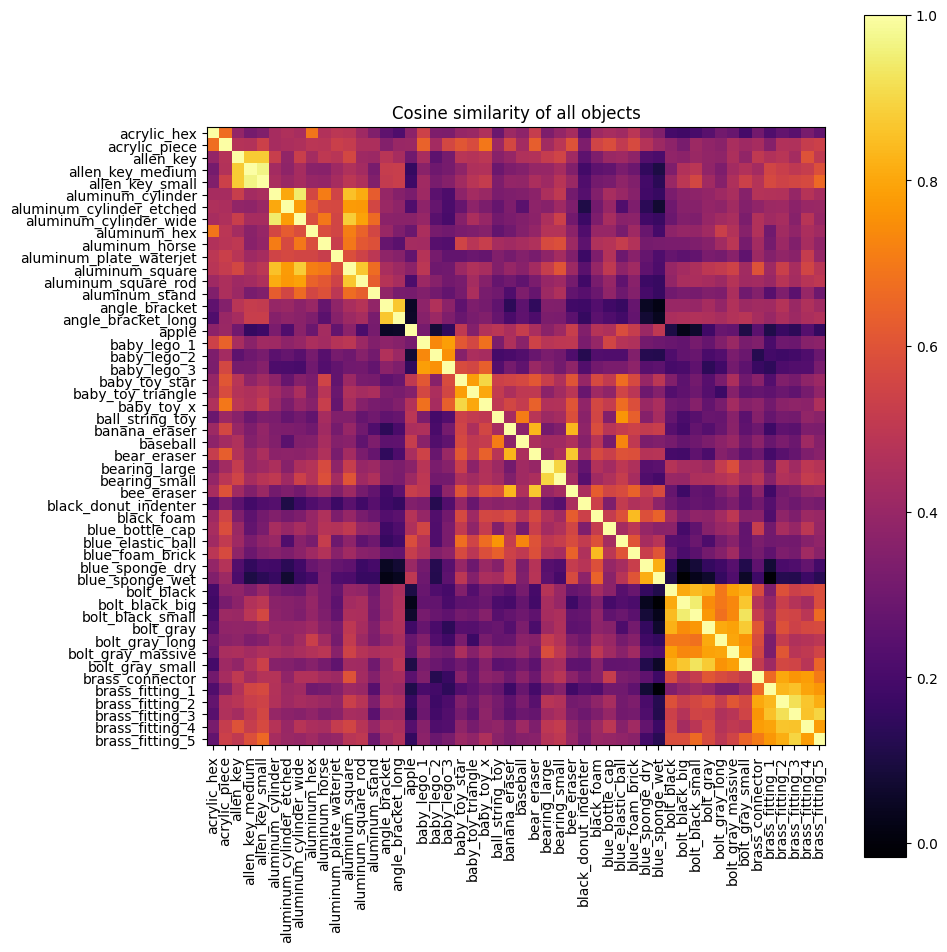

In [15]:
sample=50
matrx=np.load("/its/home/drs25/Tactile_Language_Model/data/cosine_Scores.npy")
plt.figure(figsize=(10,10))
objects=list(texture_descriptions.keys())
plt.imshow(matrx[:sample,:sample],cmap="inferno")
plt.colorbar()
plt.xticks([i for i in range(len(objects[:sample]))],objects[:sample],fontsize=10,rotation=90)
plt.yticks([i for i in range(len(objects[:sample]))],objects[:sample],fontsize=10)
plt.title("Cosine similarity of all objects")
plt.tight_layout()
plt.savefig("/its/home/drs25/Tactile_Language_Model/data/plots/cosine_example.pdf")
plt.show()